In [1]:
import tensorflow_datasets as tfds
import torch
import os

In [2]:
import torchvision
encoder = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
encoder  = torch.nn.Sequential(*list(encoder.children())[:-1])
encoder = encoder.eval().cuda()

In [3]:
#resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
import tensorflow as tf
from tqdm import tqdm

assert len(os.listdir("./datasets/ImageNet-Sketch/sketch")) == 1000
image_paths = []
labels = []
for i,f in enumerate(os.listdir("./datasets/ImageNet-Sketch/sketch")):
    for img in os.listdir("./datasets/ImageNet-Sketch/sketch"+ "/" +f):
        image_paths.append("./datasets/ImageNet-Sketch/sketch"+ "/" +f+"/"+img)
        labels.append(i)

ds = tf.data.Dataset.from_tensor_slices((image_paths,labels))
ds = ds.shuffle(buffer_size=60000)

def map(d):
    #mean=tf.convert_to_tensor([0.485, 0.456, 0.406])[None,None,:]
    #std=tf.convert_to_tensor([0.229, 0.224, 0.225])[None,None,:]
    d = d.map(lambda path,y : (tf.io.read_file(path),y))
    d = d.map(lambda raw,y : (tf.image.decode_jpeg(raw),y))
    d = d.map(lambda img,y : (tf.image.resize(img,[256,256],"bilinear"),y))
    d = d.map(lambda img,y : (tf.image.central_crop(img,0.875),y))
    d = d.map(lambda img,y : (img/127.5-1,y))

    encoded = []
    labels = []
    for img,y in tqdm(d):
        with torch.no_grad():
            img = torch.as_tensor(img.numpy())[None,:,:,:].permute(0,3,1,2).cuda()
            if img.shape[1] == 1:
                img = img.repeat(1,3,1,1)
            pred = encoder(img).reshape(-1).cpu()
        encoded.append(tf.convert_to_tensor(pred.numpy()))
        labels.append(y)
    return tf.data.Dataset.from_tensor_slices((encoded,labels))


ds_train = map(ds.take(50889-5000))
ds_test = map(ds.skip(50889-5000))

ds_train.save("./datasets/" + "imagenetsketch" + "_encoded/train")
ds_test.save("./datasets/" + "imagenetsketch" + "_encoded/test")


2024-11-15 15:21:41.979969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 15:21:41.986652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 15:21:41.993956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 15:21:41.996051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 15:21:42.002986: I tensorflow/core/platform/cpu_feature_guar

In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import pickle as pkl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np 
import os

def plot_stats(*paths):
    
    def to_plot_xyl(d,y_map_fn,label):
        items = d.items()

        return {"data" : {"x" : [item[0] for item in items], "y" : [y_map_fn(item[1]) for item in items]}, "label" : label}

    fig,axs = plt.subplots(nrows=1,ncols=len(paths))
    if len(paths) == 1:
        axs = [axs]
    fig.set_size_inches(len(paths)*4,6)
    for path,ax in zip(paths,axs):
    
        data = {"train" : {"x" : [], "y" : []}, "test" : {"x" : [], "y" : []}}
        for run in os.listdir(path):
            if not "stats" in run:
                continue

            with open(path + "/" + run,"rb") as f:
                ckpts = pkl.load(f)

            train_items = ckpts["train_acc"].items()
            data["train"]["x"].append(np.asarray([item[0] for item in train_items])) 
            data["train"]["y"].append(np.asarray([item[1] for item in train_items]))

            test_items = ckpts["test_acc"].items()
            data["test"]["x"].append(np.asarray([item[0] for item in test_items])) 
            data["test"]["y"].append(np.asarray([item[1] for item in test_items]))
        
        x = data["train"]["x"][0]
        y = np.mean(np.stack(data["train"]["y"],axis=0),axis=0)
        ax.plot(x,y, label="train acc",c="blue")

        x = data["test"]["x"][0]
        y = np.mean(np.stack(data["test"]["y"],axis=0),axis=0)
        
        ax.plot(x,y, label="test acc",c="green")
        #ax.fill_between(x, y-error, y+error,alpha=0.3)
        argmax = np.argmax(y)
        max = np.max(y)
        ax.plot([x[0],x[-1]],[max,max],c="red")
        ax.plot([x[argmax],x[argmax]],[0,1],c="red")
        ax.set_yticks((0,np.max(y),1))
        ax.legend()


def plot_states(*paths):

    def to_plot_xyl(d,y_map_fn,label):
        items = d.items()

        return {"data" : {"x" : [item[0] for item in items], "y" : [y_map_fn(item[1]) for item in items]}, "label" : label}

    def norm_2_map_fn(w):
        return jnp.linalg.matrix_norm(w["params"]["Dense_0"]["kernel"],ord=2)*jnp.linalg.matrix_norm(w["params"]["Dense_1"]["kernel"],ord=2)
    def norm_F_map_fn(w):
        return jnp.linalg.matrix_norm(w["params"]["Dense_0"]["kernel"],ord="fro")+jnp.linalg.matrix_norm(w["params"]["Dense_1"]["kernel"],ord="fro")

    fig,axs = plt.subplots(nrows=1,ncols=max(len(paths),2))
    fig.set_size_inches(len(paths)*4,6)
    for path,ax in zip(paths,axs):
        with open(path,"rb") as f:
            ckpts = pkl.load(f)

        ax.plot("x","y",**to_plot_xyl(ckpts["params"],norm_2_map_fn, "2"))
        ax.plot("x","y",**to_plot_xyl(ckpts["params"],norm_F_map_fn, "F"))
        ax.legend()

In [1]:
import os
import jax
import numpy as np
import pickle as pkl
import jax.numpy as jnp
from tqdm import tqdm
from jax.tree_util import tree_map,tree_flatten,tree_flatten_with_path,keystr
def compare_stats_settings(path):
    settings = {}
    for setting in tqdm(os.listdir(path)):
        settings[setting] = []

        for run in os.listdir(path + "/" + setting):
            if not os.path.isfile(path + "/" + setting + "/" + run + "/" + "stats.pkl"):
                continue
            with open(path + "/" + setting + "/" + run + "/" + "stats.pkl","rb") as f:
                stats = pkl.load(f)
            settings[setting].append(stats["test_acc"])

        if len(settings[setting]) > 0:
            e = tree_flatten_with_path(tree_map(lambda *x : jnp.max(jnp.stack(x)), *settings[setting]))[0]
            maximum_acc = max(e,key=lambda x : x[1])
            settings[setting] = (keystr(maximum_acc[0]),np.asarray(maximum_acc[1]))
        else:
            settings[setting] = None

    settings = {k:v for k,v in settings.items() if not v is None}

    return {max(settings,key=lambda x: settings.get(x)[1]) : settings[max(settings,key=lambda x: settings.get(x)[1])]},settings

In [ ]:

max_standard,settings_standard = compare_stats_settings("./exps/standard")
max_wd,settings_wd = compare_stats_settings("./exps/wd")
max_norm,settings_norm = compare_stats_settings("./exps/norm")
max_mean_norm,settings_mean_norm = compare_stats_settings("./exps/mean_norm")
max_svd_scale,settings_svd_scale = compare_stats_settings("./exps/svd_scale")
max_svd_exp_fit,settings_svd_exp_fit = compare_stats_settings("./exps/svd_exp_fit")
max_svd_static_exp_fit,settings_svd_static_exp_fit = compare_stats_settings("./exps/svd_static_exp_fit")
max_svd_scale_norm_equal,settings_svd_scale_norm_equal = compare_stats_settings("./exps/svd_scale_norm_equal")

100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


In [ ]:
print("max_standard: ", max_standard)
print("max_wd: ", max_wd)
print("max_norm: ", max_norm)
print("max_mean_norm: ", max_mean_norm)
print("max_svd_scale: ", max_svd_scale)
print("max_svd_exp_fit: ", max_svd_exp_fit)
print("max_svd_static_exp_fit: ", max_svd_static_exp_fit)
print("max_svd_scale_norm_equal: ", max_svd_scale_norm_equal)

max_standard:  {'standard': ('[5000]', array(0.7562, dtype=float32))}
max_wd:  {'0.004750000000000001': ('[18250]', array(0.7988, dtype=float32))}
max_norm:  {'0.2_1': ('[45000]', array(0.8166, dtype=float32))}
max_mean_norm:  {'0.2_10': ('[47000]', array(0.8170001, dtype=float32))}
max_svd_scale:  {'1_0.015_50': ('[143250]', array(0.8186, dtype=float32))}
max_svd_exp_fit:  {'0_1_100': ('[123250]', array(0.80360013, dtype=float32))}
max_svd_static_exp_fit:  {'1_1.5_100': ('[105750]', array(0.80740017, dtype=float32))}


In [63]:
A = jax.random.normal(key=jax.random.key(34),shape=(128,128))*3 + 2
print(jnp.linalg.matrix_norm(A,ord="fro"))
B = A/(jnp.linalg.matrix_norm(A,ord="fro") + 1e-7)
C = A/(jnp.linalg.vector_norm(A.reshape(-1,A.shape[-1]),axis=0)[None,:]+1e-7)
D = B/(jnp.linalg.vector_norm(B.reshape(-1,B.shape[-1]),axis=0)[None,:]+1e-7)
print(jnp.linalg.matrix_norm(B,ord="fro"))
print(jnp.linalg.matrix_norm(C,ord="fro"))
print(jnp.linalg.matrix_norm(D,ord="fro"))

print("2:", jnp.linalg.matrix_norm(A,ord=2))
print("2:", jnp.linalg.matrix_norm(B,ord=2))
print("2:", jnp.linalg.matrix_norm(C,ord=2))
print("2:", jnp.linalg.matrix_norm(D,ord=2))

464.0032
0.99999994
11.313708
11.313697
2: 265.06897
2: 0.571271
2: 6.431002
2: 6.4309936


In [11]:
A = jax.random.normal(jax.random.key(3),shape=(64,64))*5+3
print(jnp.linalg.matrix_norm(A,ord=2))
print(jnp.linalg.matrix_norm(A,ord="fro"))
print(jnp.linalg.matrix_norm(A,ord="fro")/jnp.linalg.matrix_norm(A,ord=2))
B = A/(jnp.linalg.vector_norm(A.reshape(-1,A.shape[-1]),axis=0)[None,:]+1e-7)
print(jnp.linalg.matrix_norm(B,ord=2))
print(jnp.linalg.matrix_norm(B,ord="fro"))
print(jnp.linalg.matrix_norm(B,ord="fro")/jnp.linalg.matrix_norm(B,ord=2))

200.63889
369.95514
1.8438857
4.274204
8.0
1.8716936


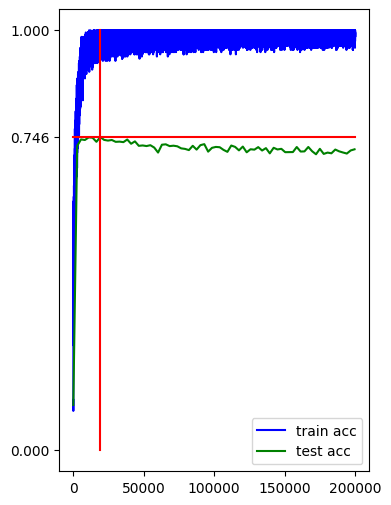

In [34]:
plot_stats("./exps/standard")

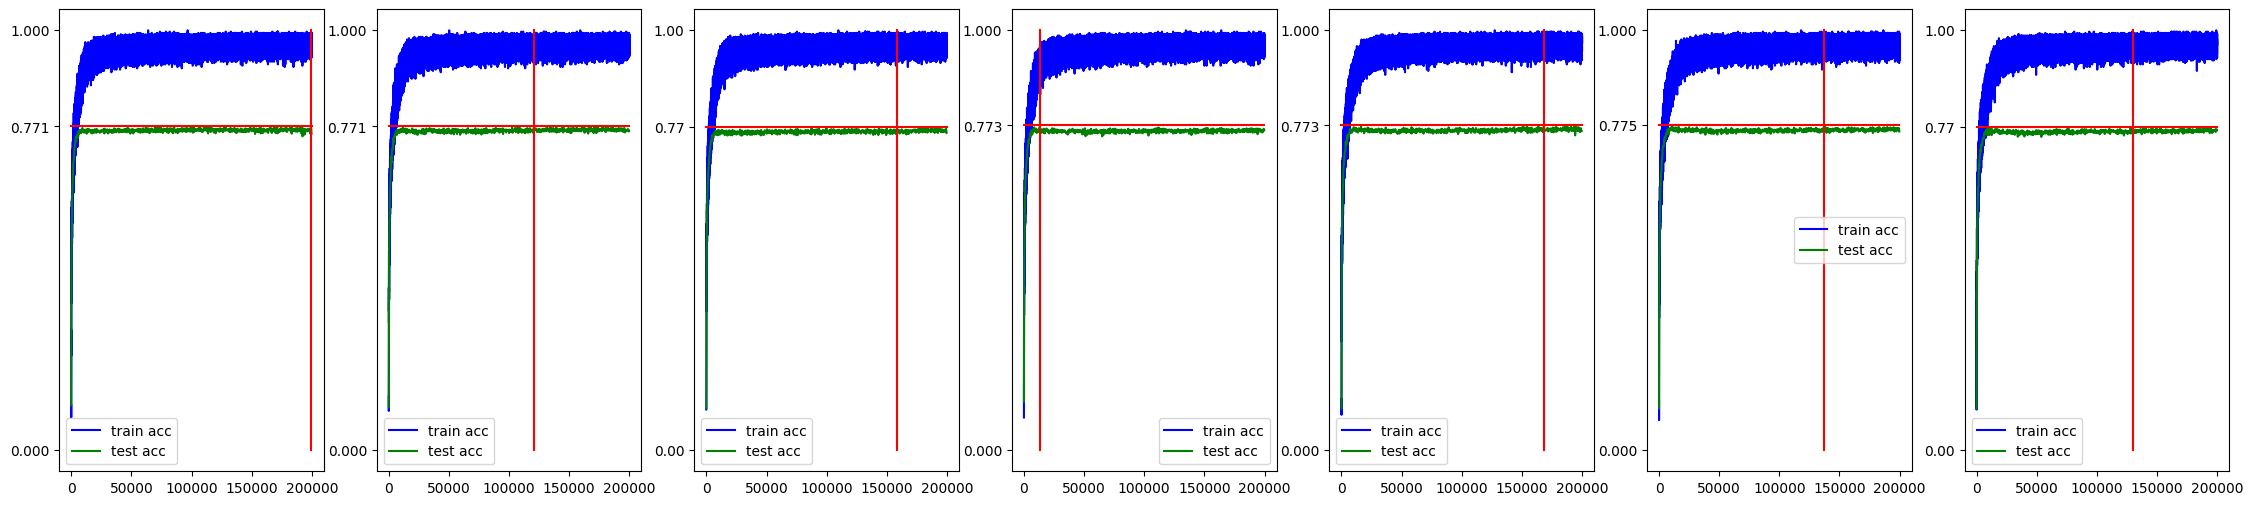

In [35]:
plot_stats("./exps/wd_0","./exps/wd_1","./exps/wd_2","./exps/wd_3","./exps/wd_4","./exps/wd_5","./exps/wd_6")

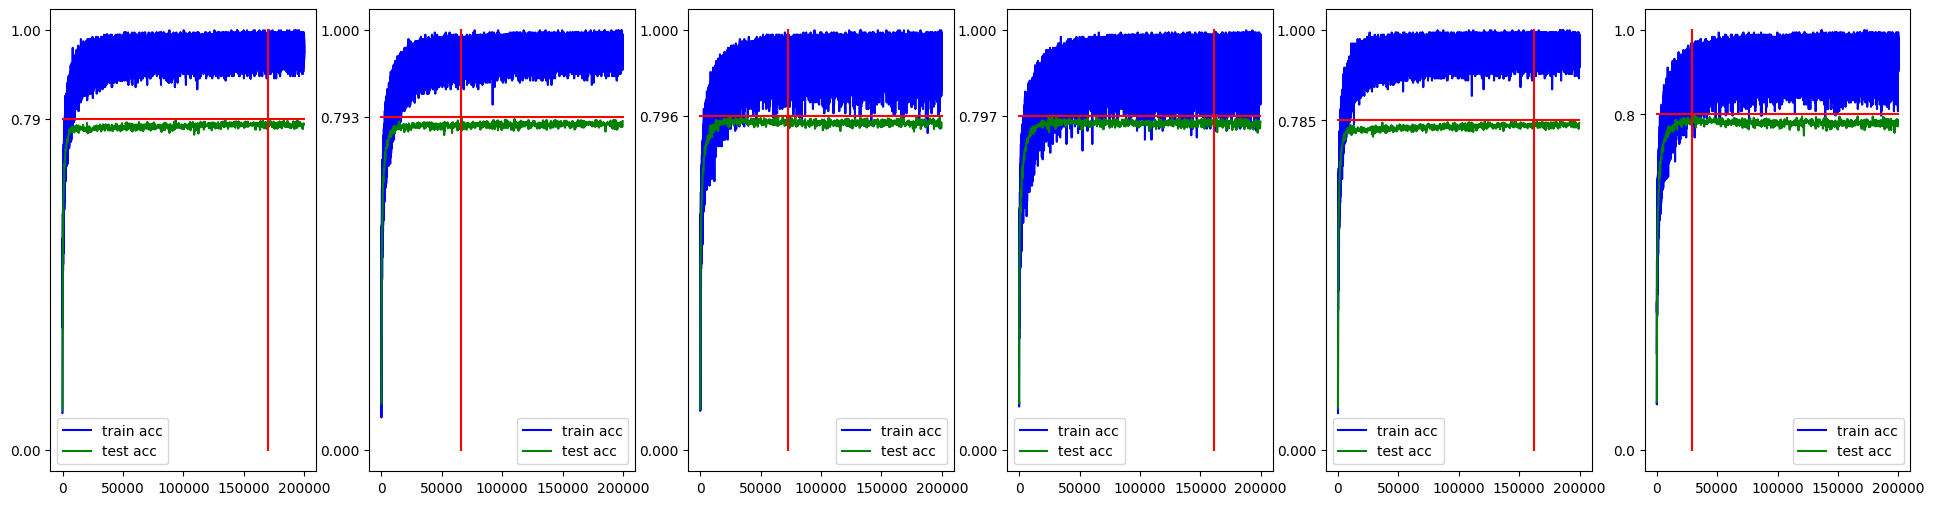

In [36]:
plot_stats("./exps/svd_1","./exps/svd_2","./exps/svd_3","./exps/svd_4","./exps/svd_5","./exps/svd_6")

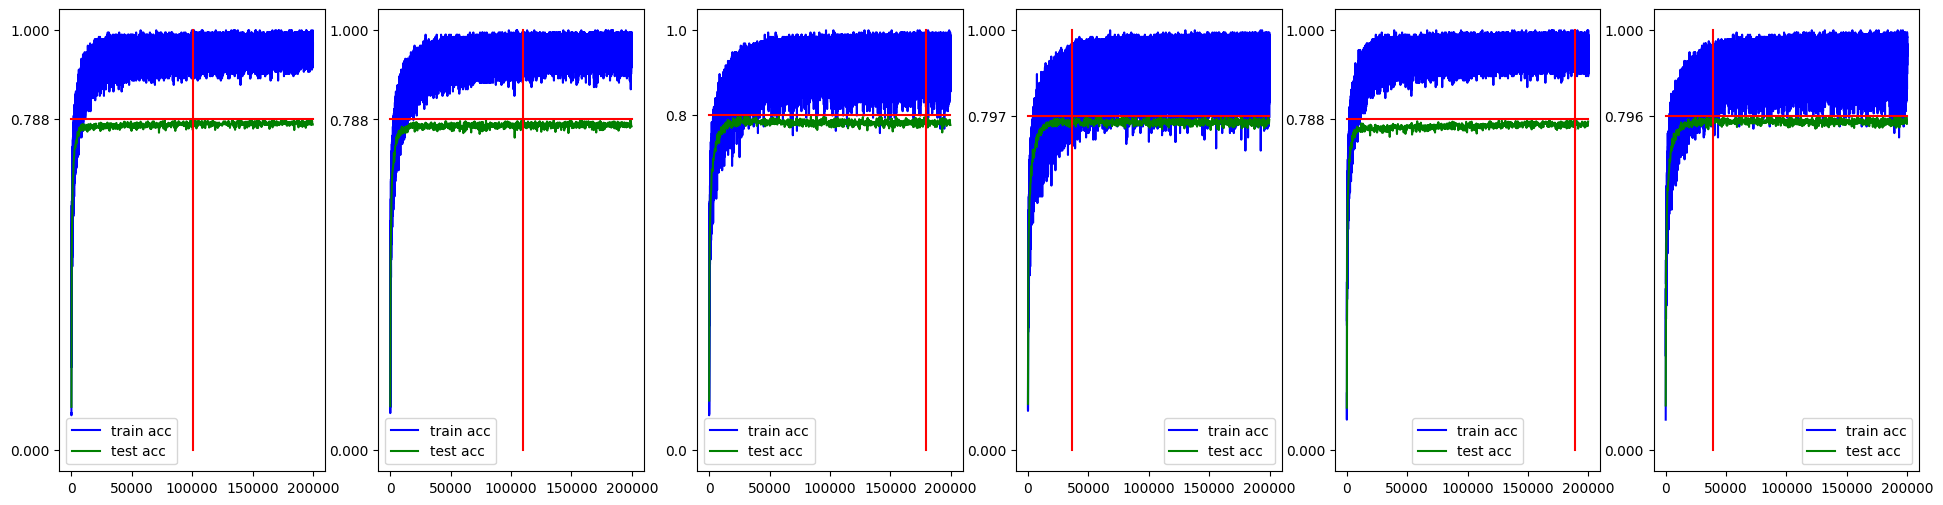

In [2]:
plot_stats("./exps/v2/svd_1","./exps/v2/svd_2","./exps/v2/svd_3","./exps/v2/svd_4","./exps/v2/svd_5","./exps/v2/svd_6")

In [ ]:
from types import SimpleNamespace

class SafeSimpleNamespace(SimpleNamespace):
    def __getattr__(self, _):
        return None

a = SafeSimpleNamespace(steps=200000)
print(a.steps)
print(a.hello)


200000
None


In [70]:
import tensorflow_datasets as tfds
import tensorflow as tf
builder = tfds.builder("cifar10",data_dir="./datasets")
builder.download_and_prepare()
ds_train,ds_test = builder.as_dataset(split=["train", "test"])

solve_dict = lambda elem : (elem["image"],elem["label"])
ds_train,ds_test = ds_train.map(solve_dict),ds_test.map(solve_dict)

cast = lambda img,lbl : (tf.cast(img,tf.dtypes.float32),lbl)
ds_train,ds_test = ds_train.map(cast),ds_test.map(cast)

mean = tf.convert_to_tensor([0.32768, 0.32768, 0.32768])[None,None,:]
std = tf.convert_to_tensor([0.27755222, 0.26925606, 0.2683012 ])[None,None,:]

normalize = lambda img,lbl : ((img/255-mean)/std,lbl)

ds_train,ds_test = ds_train.map(normalize),ds_test.map(normalize)

ds_train = [ds_train.repeat(-1).shuffle(5000).batch(64).prefetch(256).as_numpy_iterator(),ds_train.repeat(-1).shuffle(5000).batch(64).prefetch(256).as_numpy_iterator()]
ds_test = ds_test.repeat(-1).shuffle(5000).batch(512).prefetch(256).as_numpy_iterator()

def ds_stack_iterator(*ds):
    for ds_elems in zip(*ds):
        yield jnp.stack([e[0] for e in ds_elems]),jnp.stack([e[1] for e in ds_elems]) 

for (x,y) in ds_stack_iterator(*ds_train):
    print(y)
    break

2024-11-17 12:57:53.651096: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-17 12:57:53.668394: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[[9 7 7 3 4 2 0 7 8 9 7 4 4 8 9 1 8 5 2 9 1 6 4 4 1 1 5 5 1 4 2 8 1 2 4 7
  2 2 7 5 4 8 3 4 5 4 2 0 7 8 7 4 4 2 8 0 3 8 8 4 6 4 9 7]
 [8 7 1 0 1 4 0 6 3 7 8 5 3 5 8 8 5 2 3 4 4 7 9 0 3 8 1 9 8 2 8 2 1 0 7 0
  7 6 6 3 6 1 9 0 0 6 4 5 1 8 3 3 7 9 9 4 4 6 9 4 3 4 7 8]]


In [ ]:
[0.00025 + x*0.00025 for x in range(25)]

[0.0005,
 0.001,
 0.0015,
 0.002,
 0.0025,
 0.003,
 0.0035,
 0.004,
 0.0045000000000000005,
 0.005000000000000001,
 0.0055,
 0.006,
 0.006500000000000001,
 0.007000000000000001,
 0.0075,
 0.008,
 0.0085,
 0.009000000000000001,
 0.009500000000000001,
 0.01,
 0.0105,
 0.011000000000000001,
 0.0115,
 0.012,
 0.0125]